## print the Chinese CODF data

## the BII dataset
from pystac_client import Client
import rasterio

# 连接到 GEO BON STAC
stac_url = "https://stac.geobon.org"
client = Client.open(stac_url)

# 搜索 BII 10km 2020 数据
search = client.search(collections=["bii_nhm"], ids=["bii_nhm_10km_2020"])
item = next(search.items())

# 打印资产
print(item.assets.keys())

# 选择主数据资产
asset = item.assets["data"]
print(asset.href)


In [4]:
import ee 
import geemap


In [3]:
folder ='/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/'
file = 'prodes_amazonia_2024.zip'
#unzip the file
import zipfile
with zipfile.ZipFile(folder + file, 'r') as zip_ref:
    zip_ref.extractall(folder + 'prodes_amazonia_2024')


In [21]:
# 更健壮地解析本地 Codigos-da-legenda-colecao-10.csv，并根据 Class_ID 列生成 mapbiomas_palette（覆盖先前变量）
import pandas as pd, csv, sys, os

plate_file = folder + 'Codigos-da-legenda-colecao-10.csv'
print('尝试读取:', plate_file)

def read_flexible(path):
    # 多策略尝试读取 CSV，返回 DataFrame
    # 1) 直接用 pandas 读取（utf-8）
    try:
        df = pd.read_csv(path, encoding='utf-8')
        print('read_csv utf-8 success, shape:', df.shape)
        return df
    except Exception as e:
        print('read_csv utf-8 failed:', e)
    # 2) 尝试猜测分隔符
    try:
        with open(path, 'r', encoding='utf-8', errors='replace') as f:
            sample = ''.join([next(f) for _ in range(30)])
        dialect = csv.Sniffer().sniff(sample, delimiters=[',',';','	','|'])
        sep = dialect.delimiter
        print('Detected delimiter:', repr(sep))
        df = pd.read_csv(path, sep=sep, engine='python', encoding='utf-8')
        print('read_csv with detected sep success, shape:', df.shape)
        return df
    except Exception as e:
        print('delimiter detection failed or read failed:', e)
    # 3) 作为 latin1 编码再试一次并允许不规则行（skip bad lines）
    try:
        df = pd.read_csv(path, sep=None, engine='python', encoding='latin1', on_bad_lines='skip')
        print('read_csv latin1 with sep=None success, shape:', df.shape)
        return df
    except Exception as e:
        print('最后尝试失败:', e)
        raise

# 读取 DataFrame
df_local = read_flexible(plate_file)
print('Columns:', df_local.columns.tolist())

# 统一列名小写无空格，便于匹配
cols_map = {c: c.strip() for c in df_local.columns}
df_local.rename(columns=lambda x: x.strip(), inplace=True)
lc = [c.lower().replace(' ','_') for c in df_local.columns]
col_lookup = dict(zip(lc, df_local.columns))

# 找到 Class_ID 列（按你的提示）
class_candidates = ['class_id','classid','class','codigo','codigo_classe','class_code','class id','class-id']
class_col = None
for cand in class_candidates:
    if cand in col_lookup:
        class_col = col_lookup[cand]
        break
if class_col is None:
    # 作为退路，尝试匹配包含 'class' 或 'codigo' 的列名
    for k,v in col_lookup.items():
        if 'class' in k or 'codigo' in k or 'code' in k:
            class_col = v
            break
print('Using class column:', class_col)

# 寻找颜色字段（优先 hex, 否则 r,g,b）
hex_col = None
for cand in ['hex','hexadecimal','color','cor','cor_hex','rgb_hex']:
    if cand in col_lookup:
        hex_col = col_lookup[cand]
        break
r_col = col_lookup.get('r') or col_lookup.get('red') or col_lookup.get('cor_r')
g_col = col_lookup.get('g') or col_lookup.get('green') or col_lookup.get('cor_g')
b_col = col_lookup.get('b') or col_lookup.get('blue') or col_lookup.get('cor_b')
print('Detected hex_col, r,g,b:', hex_col, r_col, g_col, b_col)

# 构建 legend dict 从 Class_ID 到 hex（无#前缀，大写）
legend = {}
for idx,row in df_local.iterrows():
    try:
        key = int(row[class_col])
    except Exception:
        continue
    if hex_col and pd.notna(row.get(hex_col, None)):
        h = str(row[hex_col]).strip()
        if h.startswith('#'):
            h = h[1:]
        legend[key] = h.upper()
    elif r_col and g_col and b_col and pd.notna(row.get(r_col, None)):
        try:
            rr = int(float(row[r_col]))
            gg = int(float(row[g_col]))
            bb = int(float(row[b_col]))
            legend[key] = f"{rr:02X}{gg:02X}{bb:02X}"
        except Exception:
            legend[key] = 'FFFFFF'
    else:
        # 找不到颜色信息，使用白色占位
        legend[key] = 'FFFFFF'

print('Parsed legend entries:', len(legend))

# 你 notebook 中使用的 id 顺序（与上面相同）
mapbiomas_ids = [3,4,5,6,49,10,11,12,32,29,50,14,15,18,19,39,20,40,62,41,36,46,47,35,48,9,21,22,23,24,30]

mapbiomas_palette = []
missing = []
for cid in mapbiomas_ids:
    if cid in legend:
        mapbiomas_palette.append(legend[cid])
    else:
        missing.append(cid)
        mapbiomas_palette.append('FFFFFF')

print('Missing Class_IDs:', missing)
print('Final mapbiomas_palette (len=', len(mapbiomas_palette), '):')
print(mapbiomas_palette)

# 现在变量 mapbiomas_palette 已更新，后续可直接用于可视化


尝试读取: /projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/Codigos-da-legenda-colecao-10.csv
read_csv utf-8 failed: Error tokenizing data. C error: Expected 1 fields in line 31, saw 3

Detected delimiter: '\t'
read_csv with detected sep success, shape: (38, 5)
Columns: ['Class_ID', 'Level', 'Description', 'Descricao', 'Color']
Using class column: Class_ID
Detected hex_col, r,g,b: Color None None None
Parsed legend entries: 38
Missing Class_IDs: []
Final mapbiomas_palette (len= 31 ):
['1F8D49', '7DC975', '04381D', '026975', '02D659', 'AD975A', '519799', 'D6BC74', 'FC8114', 'FFAA5F', 'AD5100', 'FFFFB2', 'EDDE8E', 'E974ED', 'C27BA0', 'F5B3C8', 'DB7093', 'C71585', 'FF69B4', 'F54CA9', 'D082DE', 'D68FE2', '9932CC', '9065D0', 'E6CCFF', '7A5900', 'FFEFC3', 'D4271E', 'FFA07A', 'D4271E', '9C0027']


In [ ]:
import geemap as geemap
Map = geemap.Map(zoom=4)

image = ee.Image("projects/ee-zcs/assets/AMZ2018M")
image2 = ee.Image("projects/ee-zcs/assets/encoded_forest_2018")
geometry = ee.Geometry.MultiPoint(
    [[-51.98793511828675, -3.3597121934165792],
     [-49.93429108956272, -3.873897979651162],
     [-49.941039266351964, -3.8685735821872727],
     [-59.41549605870624, -16.162889421676464],
     [-53.07664992778734, -10.689647985901383],
     [-60.6311702983086, 0.9944936620321206]])
table = ee.FeatureCollection("projects/ee-zcs/assets/samples-BRAZIL")

ee.ConfusionMatrix(array=None)

Map.addLayer(image)

asset = ee.ImageCollection("projects/GLANCE/DATASETS/V001")
asset = asset.filterDate("2018-01-01", "2018-12-31").mosaic()

Map.addLayer(asset)

Map.addLayer(image2)

# 1. 定义你希望对应的四种颜色（使用十六进制颜色代码）
#    这里我随便选了 黄 红、蓝、 绿。你可以换成任何你想要的颜色。
myPalette = ['FFFF00','FF0000', '0000FF','00FF00']

# 2. 将 image2 的值 [0, 1, 10, 11] 重新映射到 [0, 1, 2, 3]
remappedImage = image2.remap(
  [0, 1, 10, 11],  # 原始值 (From values)
  [0, 1, 2, 3]     # 映射后的新值 (To values)
)

# 3. 定义可视化参数
visParams = {
  'min': 0,   # 对应新值 0
  'max': 3,   # 对应新值 3
  'palette': myPalette  # 使用上面定义的调色板
}

# 4. 将处理后的图像添加到地图，并给它一个图层名
Map.addLayer(remappedImage, visParams, 'image2 with custom colors')

img_mapbiomas = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection10/mapbiomas_brazil_collection10_integration_v2').select('classification_2018')
Map.addLayer(img_mapbiomas, {}, 'raw_mapbiomas')

# 1. 定义 MapBiomas Collection 10 的原始 ID 值
# (基于官方 Collection 10 图例)
mapbiomas_ids = [
  3, 4, 5, 6, 49, 10, 11, 12, 32, 29, 50, 14, 15, 18, 19, 39, 20, 
  40, 62, 41, 36, 46, 47, 35, 48, 9, 21, 22, 23, 24, 30
]

# 2. 定义与上述 ID 对应的调色板 (HEX 颜色代码)
# mapbiomas_palette = [
#   'FFFFFF','CE7E45','DF923D','F1A340','F1BB2D','F7F7F7',
#   'C8C8C8','7F7F7F','6F4E37','3F3F3F','F2E9E1','E6CBA8',
#   'D1C5A3','B5B29D','98B79C','6BA292','3B8E7D','2F6F6E',
#   '1F4E7A','27408F','3B2F7E','4C2D6B','5E2B58','6F2045',
#   '7F1332','8F001F','9F0010','AF0020','BF0030','CF0040','DF0050'
# ]

# 3. 将原始 ID 重新映射为从 0 到 30 的连续值
remapped_mapbiomas = img_mapbiomas.remap(
  mapbiomas_ids,               # 原始值 (From values)
  list(range(31))              # 映射后的新值 (To values)
)

# 4. 定义新的可视化参数
mapbiomasVisParams = {
  'min': 0,
  'max': 30,
  'palette': mapbiomas_palette
}

# 5. 将处理后的彩色图像添加到地图
Map.addLayer(remapped_mapbiomas, mapbiomasVisParams, 'mapbiomas (colored)')
Map.addLayer(table)

Map


In [ ]:
# Load a local Brazil administrative shapefile, convert to ee.FeatureCollection and add to Map
# The code will:
#  - look for .shp files in the folder variable (or use a specific path you provide),
#  - read with geopandas, reproject to EPSG:4326,
#  - convert to GeoJSON and create an ee.FeatureCollection,
#  - add the layer to geemap.Map and center the map on it.

import os, glob, json
try:
    import geopandas as gpd
except Exception as e:
    raise ImportError('geopandas is required to read local shapefiles. Install it in your kernel (pip install geopandas)')

# Use 'folder' defined earlier in the notebook, or set shp_path explicitly
# Example: shp_path = folder + 'brazil_admins.shp'
shp_candidates = glob.glob(os.path.join(folder, '*.shp'))
if not shp_candidates:
    raise FileNotFoundError(f'No .shp files found in {folder}. Place the shapefile there or set shp_path manually.')
# If multiple shapefiles present, pick the first or prompt (here we pick first).
shp_path = shp_candidates[0]
print('Using shapefile:', shp_path)

# Read shapefile with geopandas
gdf = gpd.read_file(shp_path)
print('Original CRS:', gdf.crs)
# Reproject to WGS84 if needed
if gdf.crs is None or gdf.crs.to_string() != 'EPSG:4326':
    try:
        gdf = gdf.to_crs(epsg=4326)
        print('Reprojected to EPSG:4326')
    except Exception as e:
        print('Warning: failed to reproject — continuing with original CRS:', e)

# Optional: reduce geometry precision to make upload lighter
# gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.0001)

# Convert to GeoJSON (dict)
geojson_dict = json.loads(gdf.to_json())

# Create an Earth Engine FeatureCollection from the GeoJSON dict
fc = ee.FeatureCollection(geojson_dict)

# Add to map with a simple style
Map.addLayer(fc, {'color': '0000FF'}, 'Brazil admins (local shapefile)')
# Center the map on the feature collection
try:
    Map.centerObject(fc, 6)
except Exception:
    # centerObject can fail if the collection is empty or too large; ignore
    pass

# If you want to upload as an Earth Engine asset (persistently), you can export:
# asset_id = 'users/your_username/brazil_admins'
# task = ee.batch.Export.table.toAsset(collection=fc, description='upload_brazil_admins', assetId=asset_id)
# task.start()
# print('Started export to', asset_id)

print('Added Brazil admin shapefile to Map as ee.FeatureCollection.')


In [ ]:
# ...existing code...
# 下载并加载巴西 municipalities（使用 pygeobr），转为 ee.FeatureCollection 并加入 Map
import geobr
import json
import geopandas as gpd

# 读取全国所有 municipality（指定年份，例如 2020 或 2019，根据需要调整）
gdf = geobr.read_municipality(year=2020)  # 或 year=2019

# 确保是 WGS84
if gdf.crs is None or gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)

# 可选：简化以减小大小
gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.001, preserve_topology=True)

# 转 GeoJSON dict，再转为 Earth Engine FeatureCollection
geojson_dict = json.loads(gdf.to_json())
fc = ee.FeatureCollection(geojson_dict)

# 将图层添加到 geemap Map
Map.addLayer(fc, {'color': '0000FF'}, 'Brazil municipalities (IBGE)')
try:
    Map.centerObject(fc, 6)
except Exception:
    pass

print('Added Brazil municipalities (year={}) to Map. Features: {}'.format(2020, len(gdf)))
# ...existing code...


In [9]:
import geopandas as gpd
import geobr
# 读取全国所有 municipality（指定年份，例如 2020 或 2019，根据需要调整）
gdf = geobr.read_municipality(year=2000)  # 或 year=2019

# 确保是 WGS84
if gdf.crs is None or gdf.crs.to_string() != 'EPSG:4326':
    gdf = gdf.to_crs(epsg=4326)


In [10]:
gdf


,code_muni,name_muni,code_state,abbrev_state,name_state,code_region,name_region,geometry
0,1100015.0,Alta Floresta D'oeste,11.0,RO,Rondônia,1.0,Norte,"POLYGON ((-62.89129 -12.86393, -62.89354 -12.8..."
1,1100023.0,Ariquemes,11.0,RO,Rondônia,1.0,Norte,"POLYGON ((-63.49994 -10.00011, -63.11257 -10.0..."
2,1100031.0,Cabixi,11.0,RO,Rondônia,1.0,Norte,"POLYGON ((-60.91954 -13.54864, -60.92424 -13.5..."
3,1100049.0,Cacoal,11.0,RO,Rondônia,1.0,Norte,"POLYGON ((-61.79389 -11.40413, -61.78481 -11.4..."
4,1100056.0,Cerejeiras,11.0,RO,Rondônia,1.0,Norte,"POLYGON ((-61.90507 -13.2755, -61.90081 -13.27..."
...,...,...,...,...,...,...,...,...
5428,5222005.0,Vianópolis,52.0,GO,Goiás,5.0,Centro-Oeste,"MULTIPOLYGON (((-48.59654 -16.92584, -48.5936 ..."
5429,5222054.0,Vicentinópolis,52.0,GO,Goiás,5.0,Centro-Oeste,"MULTIPOLYGON (((-50.0856 -17.78572, -50.08547 ..."
5430,5222203.0,Vila Boa,52.0,GO,Goiás,5.0,Centro-Oeste,"MULTIPOLYGON (((-47.21644 -14.93918, -47.21099..."
5431,5222302.0,Vila Propício,52.0,GO,Goiás,5.0,Centro-Oeste,"MULTIPOLYGON (((-49.08111 -15.48557, -49.07971..."


## Amazon comparision

In [7]:
import geopandas as gpd
import geobr
import ee 
import geemap
# 读取全国所有 municipality（指定年份，例如 2020 或 2019，根据需要调整）
local_BRshp='/projectnb/modislc/users/chishan/data/MapBiomas/BR_Municipios_2021/BR_Municipios_2021.shp'
gdf_local = gpd.read_file(local_BRshp)
gdf_local


,CD_MUN,NM_MUN,SIGLA,AREA_KM2,geometry
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8..."
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736..."
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3..."
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.0008 -11.29737, -61.00103 -11.39..."
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0..."
...,...,...,...,...,...
5567,5222005,Vianópolis,GO,954.115,"POLYGON ((-48.42801 -16.62789, -48.42803 -16.6..."
5568,5222054,Vicentinópolis,GO,733.794,"POLYGON ((-49.8474 -17.57796, -49.84719 -17.57..."
5569,5222203,Vila Boa,GO,1052.593,"POLYGON ((-47.10998 -14.67195, -47.10994 -14.6..."
5570,5222302,Vila Propício,GO,2181.593,"POLYGON ((-48.75572 -14.86393, -48.75502 -14.8..."


In [8]:
# Load Brazil biomes from geobr
biomes = geobr.read_biomes()

# Reproject to same CRS
if biomes.crs != gdf_local.crs:
    biomes = biomes.to_crs(gdf_local.crs)

# Spatial join to get municipalities within Amazon biome
gdf_amazon = gpd.sjoin(gdf_local, biomes[biomes['name_biome'] == 'Amazônia'], how='inner')
gdf_amazon = gdf_amazon.drop(columns=['index_right'])


In [ ]:
biomes


,name_biome,code_biome,year,geometry
0,Amazônia,1.0,2019.0,"MULTIPOLYGON (((-44.08515 -2.41669, -44.09068 ..."
1,Caatinga,2.0,2019.0,"MULTIPOLYGON (((-41.7408 -2.80826, -41.73291 -..."
2,Cerrado,3.0,2019.0,"MULTIPOLYGON (((-43.39009 -2.33937, -43.38741 ..."
3,Mata Atlântica,4.0,2019.0,"MULTIPOLYGON (((-48.70814 -28.44851, -48.71072..."
4,Pampa,5.0,2019.0,"MULTIPOLYGON (((-52.82472 -27.46295, -52.80293..."
5,Pantanal,6.0,2019.0,"MULTIPOLYGON (((-57.75946 -15.72779, -57.75659..."
6,Sistema Costeiro,NaN,2019.0,"MULTIPOLYGON (((-44.64799 -2.87038, -44.65184 ..."


<Axes: >

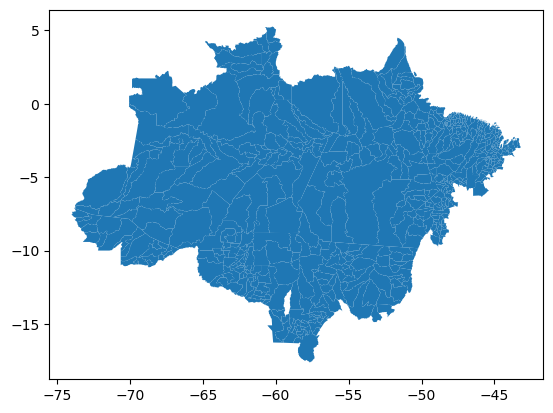

In [9]:
gdf_amazon.plot()


In [10]:
gdf_amazon.head()


,CD_MUN,NM_MUN,SIGLA,AREA_KM2,geometry,name_biome,code_biome,year
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.19465 -11.82746, -62.19332 -11.8...",Amazônia,1.0,2019.0
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-62.53648 -9.73222, -62.52765 -9.736...",Amazônia,1.0,2019.0
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.37119 -13.36655, -60.37134 -13.3...",Amazônia,1.0,2019.0
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.0008 -11.29737, -61.00103 -11.39...",Amazônia,1.0,2019.0
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-61.49976 -13.00525, -61.49809 -13.0...",Amazônia,1.0,2019.0


In [11]:
# select one county to test
gdf_amazon_county = gdf_amazon.iloc[[100]]
gdf_amazon_county


,CD_MUN,NM_MUN,SIGLA,AREA_KM2,geometry,name_biome,code_biome,year
100,1301803,Ipixuna,AM,12109.779,"POLYGON ((-70.65161 -6.63115, -70.64153 -6.813...",Amazônia,1.0,2019.0


<Axes: >

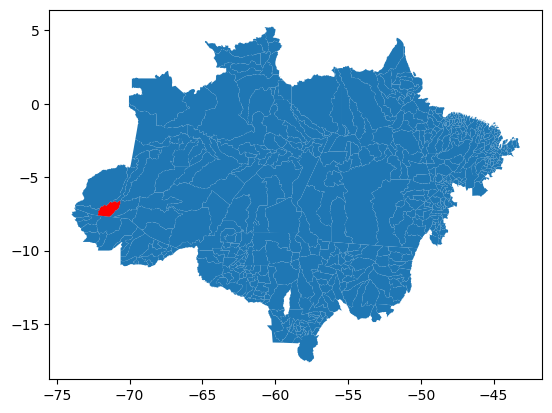

In [12]:
ax=gdf_amazon.plot()
gdf_amazon_county.plot(ax=ax, color='red')


In [18]:
# ...existing code...
# 新增单元：把你提供的 Priority Municipalities 列表精确 + 模糊匹配到 gdf_amazon 的 NM_MUN（优先用州 SIGLA）
import re, unicodedata
import pandas as pd
from difflib import get_close_matches

priority_raw = [
"Alta Floresta (MT)","Altamira (PA)","Aripuanã (MT)","Brasil Novo (PA)","Brasnorte (MT)",
"Colniza (MT)","Confresa (MT)","Cotriguaçu (MT)","Cumaru do Norte (PA)","Dom Eliseu (PA)",
"Gaúcha do Norte (MT)","Juara (MT)","Juína (MT)","Lábrea (AM)","Machadinho D´Oeste (RO)",
"Marcelândia (MT)","Nova Bandeirantes (MT)","Nova Mamoré (RO)","Nova Maringá (MT)",
"Nova Ubiratã (MT)","Novo Progresso (PA)","Novo Repartimento (PA)","Paragominas (PA)",
"Paranaíta (MT)","Peixoto de Azevedo (MT)","Pimenta Bueno (RO)","Porto dos Gaúchos (MT)",
"Porto Velho (RO)","Querência (MT)","Rondon do Pará (PA)","Santa Maria das Barreiras (PA)",
"Santana do Araguaia (PA)","São Félix do Araguaia (MT)","São Félix do Xingu (PA)",
"Ulianópolis (PA)","Vila Rica (MT)"
]

def normalize(s):
    if s is None: return ''
    s = str(s)
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    s = re.sub(r"['´`’]", '', s)          # remove apostrophes variants
    s = re.sub(r'\(.*?\)', '', s)        # remove parenthesis content
    s = re.sub(r'[^a-z0-9\s]', ' ', s)   # keep alnum + spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# parse provided list into name + state
rows = []
for p in priority_raw:
    m = re.match(r'^(.*?)\s*\((\w{2})\)\s*$', p)
    if m:
        name, state = m.group(1).strip(), m.group(2).upper()
    else:
        name, state = p.strip(), ''
    rows.append({'orig': p, 'name': name, 'state': state, 'norm': normalize(name)})

prio_df = pd.DataFrame(rows)

# require gdf_amazon with NM_MUN and SIGLA
if 'gdf_amazon' not in globals():
    raise RuntimeError("gdf_amazon not found - run the cell that builds it first.")
for col in ('NM_MUN','SIGLA'):
    if col not in gdf_amazon.columns:
        raise KeyError(f"gdf_amazon missing required column: {col}")

gdf_amazon = gdf_amazon.copy()
gdf_amazon['nm_norm'] = gdf_amazon['NM_MUN'].astype(str).apply(normalize)
gdf_amazon['sigla_up'] = gdf_amazon['SIGLA'].astype(str).str.upper().str.strip()
gdf_amazon['priority'] = False
gdf_amazon['priority_source'] = None
gdf_amazon['priority_score'] = None

# prepare candidates grouped by state for faster/safer matching
cands_by_state = {}
for st, grp in gdf_amazon.groupby('sigla_up'):
    cands_by_state[st] = grp['nm_norm'].tolist()
# global candidate list if no state given
global_cands = gdf_amazon['nm_norm'].tolist()

# prefer rapidfuzz if available
use_rapid = False
try:
    from rapidfuzz import process, fuzz
    use_rapid = True
except Exception:
    use_rapid = False

matched = []
unmatched = []

for _, prow in prio_df.iterrows():
    target_norm = prow['norm']
    state = prow['state']
    candidates = cands_by_state.get(state, []) if state else global_cands

    # exact match (name + state)
    exact_idx = gdf_amazon[(gdf_amazon['nm_norm'] == target_norm) & ((gdf_amazon['sigla_up'] == state) | (state==''))].index
    if len(exact_idx):
        ix = exact_idx[0]
        gdf_amazon.at[ix, 'priority'] = True
        gdf_amazon.at[ix, 'priority_source'] = prow['orig'] + ' (exact)'
        gdf_amazon.at[ix, 'priority_score'] = 100
        matched.append(prow['orig'])
        continue

    # fuzzy match restricted to same state if candidates exist, else global
    match_label = None
    score = None
    if candidates:
        if use_rapid:
            res = process.extractOne(target_norm, candidates, scorer=fuzz.ratio)
            if res:
                match_label, score = res[0], int(res[1])
        else:
            matches = get_close_matches(target_norm, candidates, n=1, cutoff=0.8)
            if matches:
                match_label = matches[0]
                score = None
    # apply match if above threshold
    if match_label and (score is None or score >= 80):
        ix = gdf_amazon[gdf_amazon['nm_norm'] == match_label].index
        if len(ix):
            gdf_amazon.loc[ix, 'priority'] = True
            suffix = f' (fuzzy {score})' if score is not None else ' (fuzzy)'
            gdf_amazon.loc[ix, 'priority_source'] = prow['orig'] + suffix
            gdf_amazon.loc[ix, 'priority_score'] = score if score is not None else 90
            matched.append(prow['orig'])
            continue

    # if reached here, not matched
    unmatched.append(prow['orig'])

# summary prints
print("Matched (count):", len(matched))
print("Matched list:", matched)
print("Unmatched (count):", len(unmatched))
print("Unmatched list:", unmatched)

# show matched rows
print("\nMatches in gdf_amazon:")
print(gdf_amazon.loc[gdf_amazon['priority'], ['CD_MUN','NM_MUN','SIGLA','priority_source','priority_score']].to_string(index=False))

# # add layer to Map if present
# try:
#     import ee, json
#     matched_gdf = gdf_amazon[gdf_amazon['priority']]
#     if not matched_gdf.empty and 'Map' in globals():
#         geojson_dict = json.loads(matched_gdf.to_json())
#         fc = ee.FeatureCollection(geojson_dict)
#         Map.addLayer(fc, {'color':'FF0000'}, 'Priority municipalities (provided list)')
#         print("Added Map layer: Priority municipalities (provided list)")
# except Exception as e:
#     print("Could not add Map layer:", e)
# ...existing code...
blacklist=gdf_amazon.loc[gdf_amazon['priority'], ['CD_MUN']]


Matched (count): 36
Matched list: ['Alta Floresta (MT)', 'Altamira (PA)', 'Aripuanã (MT)', 'Brasil Novo (PA)', 'Brasnorte (MT)', 'Colniza (MT)', 'Confresa (MT)', 'Cotriguaçu (MT)', 'Cumaru do Norte (PA)', 'Dom Eliseu (PA)', 'Gaúcha do Norte (MT)', 'Juara (MT)', 'Juína (MT)', 'Lábrea (AM)', 'Machadinho D´Oeste (RO)', 'Marcelândia (MT)', 'Nova Bandeirantes (MT)', 'Nova Mamoré (RO)', 'Nova Maringá (MT)', 'Nova Ubiratã (MT)', 'Novo Progresso (PA)', 'Novo Repartimento (PA)', 'Paragominas (PA)', 'Paranaíta (MT)', 'Peixoto de Azevedo (MT)', 'Pimenta Bueno (RO)', 'Porto dos Gaúchos (MT)', 'Porto Velho (RO)', 'Querência (MT)', 'Rondon do Pará (PA)', 'Santa Maria das Barreiras (PA)', 'Santana do Araguaia (PA)', 'São Félix do Araguaia (MT)', 'São Félix do Xingu (PA)', 'Ulianópolis (PA)', 'Vila Rica (MT)']
Unmatched (count): 0
Unmatched list: []

Matches in gdf_amazon:
 CD_MUN                    NM_MUN SIGLA                        priority_source priority_score
1100130        Machadinho D'Oeste   

In [ ]:
#transfer blacklist['CD_MUN'] to list
blacklist=blacklist['CD_MUN'].tolist()


In [ ]:
blacklist


['1100130',
 '1100189',
 '1100205',
 '1100338',
 '1302405',
 '1500602',
 '1501725',
 '1502764',
 '1502939',
 '1505031',
 '1505064',
 '1505502',
 '1506187',
 '1506583',
 '1506708',
 '1507300',
 '1508126',
 '5100250',
 '5101407',
 '5101902',
 '5103254',
 '5103353',
 '5103379',
 '5103858',
 '5105101',
 '5105150',
 '5105580',
 '5106158',
 '5106240',
 '5106299',
 '5106422',
 '5106802',
 '5107065',
 '5107859',
 '5108600',
 '5108907']

In [1]:
import ee
import geemap

ee.Initialize()
# studyArea = geemap.geopandas_to_ee(gdf_amazon_county)
# studyArea


In [26]:
shp_brazil = ee.FeatureCollection('projects/ee-zcs/assets/BR_Municipios_2021').filter(ee.Filter.inList('CD_MUN',blacklist))


In [27]:
shp_brazil


In [28]:
Map=geemap.Map(zoom=5)
Map.add_basemap('SATELLITE')
# Map.addLayer(studyArea, {}, 'study area')
# Map.centerObject(studyArea, 6)
Map.addLayer(shp_brazil,{},'amazon shp')
Map


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

In [29]:
studyArea=shp_brazil.filter(ee.Filter.eq('CD_MUN','1507300')).first()
studyArea


In [31]:
year = 2018
img_glance = ee.ImageCollection("projects/GLANCE/DATASETS/V001").filterDate(f"{year}-01-01", f"{year}-12-31").select('LC').mosaic()
# Map.addLayer(img_glance, {}, 'GLANCE 2018')

# remap the glance to forest and non-forest
# 1. 定义原始 GLANCE 分类值和对应的新值
from_values = [5]
to_values = [1]  # 1 表示森林
img_glance_remap = img_glance.remap(from_values, to_values, 0)  # 其他值映射为 0（非森林）
Map.addLayer(img_glance_remap, {'min':0, 'max':1, 'palette':['red','green']}, 'GLANCE remapped')


In [55]:
# Hansen forest extent for 2018, correctly handling lossyear masking
year = 2018
hansen = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')

# Bands
tc = hansen.select('treecover2000')
ly = hansen.select('lossyear')      # 1..24 (2001..2024); masked where no loss
gain = hansen.select('gain')        # 1 where gain (2001-2012)

# Forest baseline at 2000 using 30% threshold
forest2000 = tc.gte(30)

# Loss through target year (inclusive), taking care of masked 'no loss' values
ly0 = ly.unmask(0)

lossThroughYear = ly0.gte(1).And(ly0.lt(year - 2000))   # 1..18 means loss by 2018

# Remaining forest in target year (subtract losses through that year)
forest_year = forest2000.And(lossThroughYear.Not())

# Optional: include gain (2001-2012) that has not been lost again by the target year
# Note: 'gain' doesn't encode a threshold; common practice is to OR gains that remain.
gainedStill = gain.eq(1).And(lossThroughYear.Not())
forest_year_with_gain = forest_year.Or(gainedStill)

# Visualize
Map.addLayer(forest_year, {'palette': ['red','green']}, f'Forest {year} (no gain)')
Map.addLayer(forest_year_with_gain, {'palette': ['red','green']}, f'Forest {year} (+gain 01-12)')
# Map.addLayer(lossThroughYear.selfMask(), {'palette': ['FF0000']}, f'Loss <= {year}')


1 (Forest)
3 (Forest Formation)
4 (Savanna Formation)
5 (Mangrove)
6 (Floodable Forest)
49 (Wooded Sandbank Vegetation)

In [32]:
# add mapbiomas layer and remap to forest/non-forest for the selected year
# Assumptions:
# - Native forest classes: 3 (Forest Formation), 5 (Mangrove), 6 (Flooded Forest)
# Adjust the class lists below as needed for your analysis.

img_mapbiomas = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection10/mapbiomas_brazil_collection10_integration_v2').select(f'classification_{year}')

native_forest_classes = [1, 3, 4, 5, 6, 49]

# Binary masks: 1 = forest, 0 = non-forest
img_mb_forest_native = img_mapbiomas.remap(native_forest_classes, [1]*len(native_forest_classes), 0)


# Visualize (mask non-forest for cleaner view)
Map.addLayer(img_mb_forest_native, {'min':0, 'max':1, 'palette':['red','green']}, f'MapBiomas forest {year} (native)')


In [ ]:
Map.add(shp_brazil)


In [30]:
img_terra = ee.Image('projects/ee-zcs/assets/AMZ2018M').select('b1')
Map.addLayer(img_terra, {}, 'TerraClass AMZ 2018')

#remap TerraClass to forest/non-forest
terra_forest_classes = [1, 2, 9]  # Uncomment to include plantations

img_terra_forest = img_terra.remap(terra_forest_classes, [1]*len(terra_forest_classes), 0)
Map.addLayer(img_terra_forest, {'min':0, 'max':1, 'palette':['red','green']}, 'TerraClass forest 2018')


In [46]:
def te_loss_km2(y):
    # if y is not even
    if y % 2 != 0:
        y=y+1

    TE_IMG = ee.Image(f'projects/ee-zcs/assets/AMZ{y}M')
    forest_classes = [1, 2]
    
    def te_forest(y):
        band = 'b1'
        img = TE_IMG.select(band)
        forest = img.remap(forest_classes, [1]*len(forest_classes), 0).rename('forest')
        return forest
    
    f_y = te_forest(y-2)
    f_y1 = te_forest(y)
    Map.addLayer(f_y1, {'min':0, 'max':1, 'palette':['red','green']}, f'TerraClass forest {y} v2')
    Map.addLayer(f_y, {'min':0, 'max':1, 'palette':['red','green']}, f'TerraClass forest {y-2} v2')

    loss = f_y.And(f_y1.Not()).rename('loss')
    area = loss.multiply(pixel_area_km2).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=study_geom, scale=30, maxPixels=1e13
    ).get('loss')

    return ee.Number(area)

print(te_loss_km2(2018).getInfo())
Map.addLayer(study_geom, {}, 'study area')


0


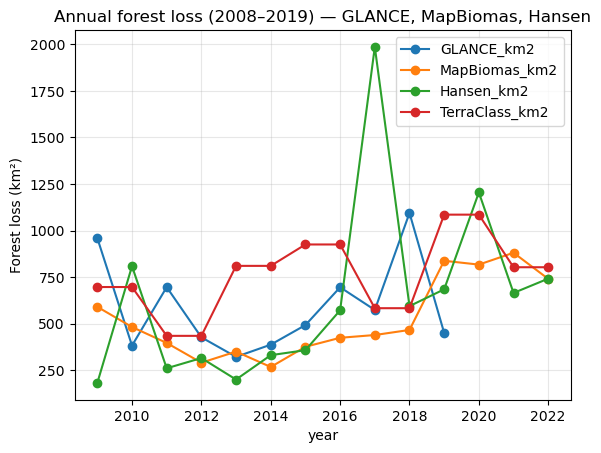

,GLANCE_km2,MapBiomas_km2,Hansen_km2,TerraClass_km2
year,,,,
2009,959.546321,590.483066,181.907717,696.897313
2010,382.282624,482.109697,808.851659,696.897313
2011,696.311498,396.613205,260.522172,434.692495
2012,426.739706,290.481927,315.394665,434.692495
2013,321.857358,350.031040,200.064461,810.496911
2014,387.412610,267.560818,330.944068,810.496911
2015,492.598828,375.976295,357.776321,925.408165
2016,695.656765,424.299473,571.879419,925.408165
2017,573.810302,439.110837,1986.298031,583.190469


In [48]:
# Annual forest loss time series (2008–2019) for GLANCE, Hansen, MapBiomas over studyArea
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Ensure EE is initialized
try:
    ee.Initialize()
except Exception:
    ee.Initialize()

# Require a studyArea geometry
try:
    study_geom = studyArea.geometry()
except Exception as e:
    raise RuntimeError('studyArea is not defined. Run the cell that creates studyArea before this one.')

# Common config
years = list(range(2009, 2023))  # inclusive end year for per-year loss (y to y+1) where applicable
pixel_area_km2 = ee.Image.pixelArea().divide(1e6)

# ---------------------
# Hansen annual loss
# ---------------------
hansen = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')
tc = hansen.select('treecover2000')
forest2000 = tc.gte(30)
ly = hansen.select('lossyear')  # 1..24 => 2001..2024, masked where no loss

def hansen_loss_km2(y):
    code = y - 2000
    # Annual loss in year y (intersect with forest2000)
    loss_y = ly.eq(code).And(forest2000).rename('loss')
    area = loss_y.multiply(pixel_area_km2).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=study_geom, scale=30, maxPixels=1e13
    ).get('loss')
    return ee.Number(area)

# ---------------------
# GLANCE annual loss (forest = LC==5)
# ---------------------
GLANCE_IC = ee.ImageCollection('projects/GLANCE/DATASETS/V001')

def glance_forest(y):
    img = GLANCE_IC.filterDate(f'{y}-01-01', f'{y}-12-31').select('LC').mosaic()
    return img.eq(5).rename('forest')

def glance_loss_km2(y):
    # Loss from y to y+1: forest(y) -> non-forest(y+1)
    f_y = glance_forest(y-1)
    f_y1 = glance_forest(y)
    loss = f_y.And(f_y1.Not()).rename('loss')
    area = loss.multiply(pixel_area_km2).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=study_geom, scale=30, maxPixels=1e13
    ).get('loss')
    return ee.Number(area)

# ---------------------
# MapBiomas annual loss (forest classes = [1,3,4,5,6,49])
# ---------------------
MB_IMG = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection10/mapbiomas_brazil_collection10_integration_v2')
forest_classes = [1, 3, 4, 5, 6, 49]

def mb_forest(y):
    band = f'classification_{y}'
    img = MB_IMG.select(band)
    forest = img.remap(forest_classes, [1]*len(forest_classes), 0).rename('forest')
    return forest

def mb_loss_km2(y):
    f_y = mb_forest(y-1)
    f_y1 = mb_forest(y)
    loss = f_y.And(f_y1.Not()).rename('loss')
    area = loss.multiply(pixel_area_km2).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=study_geom, scale=30, maxPixels=1e13
    ).get('loss')
    return ee.Number(area)

# ---------------------
# TerraClass annual loss (forest classes = [1,3,4,5,6,49])
# ---------------------
def te_loss_km2(y):
    # if y is not even
    if y % 2 != 0:
        y=y+1

    forest_classes = [1, 2]
    
    def te_forest(y):
        TE_IMG = ee.Image(f'projects/ee-zcs/assets/AMZ{y}M')
        band = 'b1'
        img = TE_IMG.select(band)
        forest = img.remap(forest_classes, [1]*len(forest_classes), 0).rename('forest')
        return forest
    
    f_y = te_forest(y-2)
    f_y1 = te_forest(y)
    loss = f_y.And(f_y1.Not()).rename('loss')
    area = loss.multiply(pixel_area_km2).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=study_geom, scale=30, maxPixels=1e13
    ).get('loss')

    return ee.Number(area)

# Compute series
rows = []
for y in years:
    # For GLANCE/MapBiomas, rely on y+1; if not available, set to None
    try:
        gl_km2 = glance_loss_km2(y).getInfo()
    except Exception:
        gl_km2 = None
    try:
        mb_km2 = mb_loss_km2(y).getInfo()
    except Exception:
        mb_km2 = None
    # Hansen uses lossyear directly; should be available
    try:
        hs_km2 = hansen_loss_km2(y).getInfo()
    except Exception:
        hs_km2 = None
    # terraClass loss
    try:
        te_km2 = te_loss_km2(y).getInfo()/2
    except Exception:
        te_km2 = None

    rows.append({'year': y, 'GLANCE_km2': gl_km2, 'MapBiomas_km2': mb_km2, 'Hansen_km2': hs_km2, 'TerraClass_km2': te_km2})

# Plot
df = pd.DataFrame(rows).set_index('year')
ax = df.plot(marker='o')
ax.set_ylabel('Forest loss (km²)')
ax.set_title('Annual forest loss (2008–2019) — GLANCE, MapBiomas, Hansen')
ax.grid(True, alpha=0.3)
plt.show()

df


In [37]:
y=2009
if y % 2 != 0:
    y=y+1
print(y)


2010


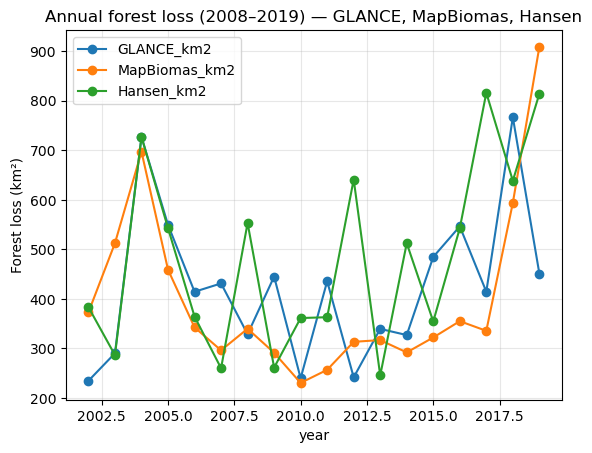

,GLANCE_km2,MapBiomas_km2,Hansen_km2
year,,,
2002,234.733388,373.005041,383.382480
2003,290.351976,512.643728,286.560221
2004,726.999264,697.104385,727.168249
2005,549.499581,458.939889,542.744230
2006,414.458311,342.640811,364.416945
2007,431.245222,296.208454,260.076497
2008,328.797956,339.802539,553.116561
2009,445.049191,291.298116,261.364093
2010,239.895058,230.450681,361.375498


In [5]:
# Annual forest loss time series (2008–2019) for GLANCE, Hansen, MapBiomas over studyArea
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# Ensure EE is initialized
try:
    ee.Initialize()
except Exception:
    ee.Initialize()

studyArea=shp_brazil.filter(ee.Filter.eq('CD_MUN','1500602')).first()

# Require a studyArea geometry
try:
    study_geom = studyArea.geometry()
except Exception as e:
    raise RuntimeError('studyArea is not defined. Run the cell that creates studyArea before this one.')

# Common config
years = list(range(2002, 2020))  # inclusive end year for per-year loss (y to y+1) where applicable
pixel_area_km2 = ee.Image.pixelArea().divide(1e6)

# ---------------------
# Hansen annual loss
# ---------------------
hansen = ee.Image('UMD/hansen/global_forest_change_2024_v1_12')
tc = hansen.select('treecover2000')
forest2000 = tc.gte(30)
ly = hansen.select('lossyear')  # 1..24 => 2001..2024, masked where no loss

def hansen_loss_km2(y):
    code = y - 2000
    # Annual loss in year y (intersect with forest2000)
    loss_y = ly.eq(code).And(forest2000).rename('loss')
    area = loss_y.multiply(pixel_area_km2).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=study_geom, scale=30, maxPixels=1e13
    ).get('loss')
    return ee.Number(area)

# ---------------------
# GLANCE annual loss (forest = LC==5)
# ---------------------
GLANCE_IC = ee.ImageCollection('projects/GLANCE/DATASETS/V001')

def glance_forest(y):
    img = GLANCE_IC.filterDate(f'{y}-01-01', f'{y}-12-31').select('LC').mosaic()
    return img.eq(5).rename('forest')

def glance_loss_km2(y):
    # Loss from y to y+1: forest(y) -> non-forest(y+1)
    f_y = glance_forest(y-1)
    f_y1 = glance_forest(y)
    loss = f_y.And(f_y1.Not()).rename('loss')
    area = loss.multiply(pixel_area_km2).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=study_geom, scale=30, maxPixels=1e13
    ).get('loss')
    return ee.Number(area)

# ---------------------
# MapBiomas annual loss (forest classes = [1,3,4,5,6,49])
# ---------------------
MB_IMG = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection10/mapbiomas_brazil_collection10_integration_v2')
forest_classes = [1, 3, 4, 5, 6, 49]

def mb_forest(y):
    band = f'classification_{y}'
    img = MB_IMG.select(band)
    forest = img.remap(forest_classes, [1]*len(forest_classes), 0).rename('forest')
    return forest

def mb_loss_km2(y):
    f_y = mb_forest(y-1)
    f_y1 = mb_forest(y)
    loss = f_y.And(f_y1.Not()).rename('loss')
    area = loss.multiply(pixel_area_km2).reduceRegion(
        reducer=ee.Reducer.sum(), geometry=study_geom, scale=30, maxPixels=1e13
    ).get('loss')
    return ee.Number(area)

# Compute series
rows = []
for y in years:
    # For GLANCE/MapBiomas, rely on y+1; if not available, set to None
    try:
        gl_km2 = glance_loss_km2(y).getInfo()
    except Exception:
        gl_km2 = None
    try:
        mb_km2 = mb_loss_km2(y).getInfo()
    except Exception:
        mb_km2 = None
    # Hansen uses lossyear directly; should be available
    try:
        hs_km2 = hansen_loss_km2(y).getInfo()
    except Exception:
        hs_km2 = None
    rows.append({'year': y, 'GLANCE_km2': gl_km2, 'MapBiomas_km2': mb_km2, 'Hansen_km2': hs_km2})

# Plot
df = pd.DataFrame(rows).set_index('year')
ax = df.plot(marker='o')
ax.set_ylabel('Forest loss (km²)')
ax.set_title('Annual forest loss (2008–2019) — GLANCE, MapBiomas, Hansen')
ax.grid(True, alpha=0.3)
plt.show()

df


In [54]:
# read all qml files for terraClass to know the forest classes of each year
import os
from xml.etree import ElementTree as ET

def read_terra_class_qml(year):
    qml_file = f'/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/AMZ.{year}.M.qml'

    forest_classes = {}
    tree = ET.parse(qml_file)
    root = tree.getroot()
    for class_elem in root.findall('.//class'):
        class_id = int(class_elem.get('id'))
        class_name = class_elem.get('name')
        forest_classes[class_id] = class_name
    return forest_classes

terra_class_forest_classes = {}
for year in range(2008, 2020, 2):
    terra_class_forest_classes[year] = read_terra_class_qml(year)

terra_class_forest_classes


{2008: {}, 2010: {}, 2012: {}, 2014: {}, 2016: {}, 2018: {}}

In [56]:
# ...existing code...
# read all qml files for terraClass to know the forest classes of each year
import os
from xml.etree import ElementTree as ET
import re

def read_terra_class_qml(year):

    classes = {}
    parsed_any = False
    qml_file = f'/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/AMZ.{year}.M.qml'

    try:
        tree = ET.parse(qml_file)
        root = tree.getroot()
    except Exception as e:
        # skip unreadable files
        return None

    # Try common element names used in QGIS QMLs; fallback to generic items
    elems = root.findall('.//class') or root.findall('.//item') or root.findall('.//paletteEntry') or root.findall('.//entry')
    if not elems:
        elems = list(root.iter())
    for elem in elems:
        # try several ways to find id and label/name
        id_attr = elem.get('id') or elem.get('value') or elem.get('key')
        if id_attr is None:
            id_text = elem.findtext('id') or elem.findtext('value')
        else:
            id_text = id_attr
        if id_text is None:
            continue
        try:
            cid = int(re.sub(r'\D', '', str(id_text)))
        except Exception:
            continue
        label = elem.get('name') or elem.get('label') or elem.findtext('label') or elem.findtext('name') or (elem.findtext('value') if elem.findtext('value') else '')
        label = (label or '').strip()
        classes[cid] = label
        parsed_any = True


    # Determine forest classes by keywords (conservative)
    kws = ['forest', 'floresta', 'mangrove', 'manguezal', 'mangue', 'mata', 'florestal', 'plantation', 'plantio', 'silvicultura']
    forest_ids = [cid for cid, name in classes.items() if any(k in (name or '').lower() for k in kws)]

    return {'classes': classes, 'forest_ids': sorted(forest_ids)}

terra_class_forest_classes = {}
for year in range(2008, 2020, 2):
    terra_class_forest_classes[year] = read_terra_class_qml(year)

terra_class_forest_classes
# ...existing code...


{2008: {'classes': {1: 'VEGETACAO NATURAL FLORESTAL PRIMARIA',
   2: 'VEGETACAO NATURAL FLORESTAL SECUNDARIA',
   9: 'SILVICULTURA',
   10: 'PASTAGEM ARBUSTIVA/ARBOREA',
   11: 'PASTAGEM HERBACEA',
   12: 'CULTURA AGRICOLA PERENE',
   13: 'CULTURA AGRICOLA SEMIPERENE',
   16: 'MINERACAO',
   17: 'URBANIZADA',
   20: 'OUTROS USOS',
   22: 'DESFLORESTAMENTO NO ANO',
   23: 'CORPO DAGUA',
   25: 'NAO OBSERVADO',
   50: 'NAO FLORESTA',
   52: 'CULTURA AGRICOLA TEMPORARIA'},
  'forest_ids': [1, 2, 9, 22, 50]},
 2010: {'classes': {1: 'VEGETACAO NATURAL FLORESTAL PRIMARIA',
   2: 'VEGETACAO NATURAL FLORESTAL SECUNDARIA',
   9: 'SILVICULTURA',
   10: 'PASTAGEM ARBUSTIVA/ARBOREA',
   11: 'PASTAGEM HERBACEA',
   12: 'CULTURA AGRICOLA PERENE',
   13: 'CULTURA AGRICOLA SEMIPERENE',
   16: 'MINERACAO',
   17: 'URBANIZADA',
   20: 'OUTROS USOS',
   22: 'DESFLORESTAMENTO NO ANO',
   23: 'CORPO DAGUA',
   25: 'NAO OBSERVADO',
   50: 'NAO FLORESTA',
   52: 'CULTURA AGRICOLA TEMPORARIA'},
  'forest_ids'

In [ ]:
%run /usr2/postdoc/chishan/research/CODF/20251028_export_loss_by_municipality.py


Processing Hansen dataset...
  Hansen year 2009
  Hansen year 2010
  Hansen year 2011
  Hansen year 2012
  Hansen year 2013
  Hansen year 2014
  Hansen year 2015
  Hansen year 2016
  Hansen year 2017
  Hansen year 2018
  Hansen year 2019
  Hansen year 2020
  Hansen year 2021
  Hansen year 2022
Hansen export started. Task id: 2IPP22GKLZKV3IIC53KPKUT5
Processing GLANCE dataset...
  GLANCE year 2009
  GLANCE year 2010
  GLANCE year 2011
  GLANCE year 2012
  GLANCE year 2013
  GLANCE year 2014
  GLANCE year 2015
  GLANCE year 2016
  GLANCE year 2017
  GLANCE year 2018
  GLANCE year 2019
  GLANCE year 2020
  GLANCE data not available for 2020, skipping
  GLANCE year 2021
  GLANCE data not available for 2021, skipping
  GLANCE year 2022
  GLANCE data not available for 2022, skipping
GLANCE export started. Task id: 43NEUXZCYGEOMID3VCRAQAVD
Processing MapBiomas dataset...
  MapBiomas year 2009
  MapBiomas year 2010
  MapBiomas year 2011
  MapBiomas year 2012
  MapBiomas year 2013
  MapBiomas y